In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import shutil
import seaborn as sns
import os
import zipfile

In [2]:
!conda install -y gdown

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.10.0      |     pyha770c72_0          77 KB  conda-forge
    conda-4.11.0               |   py37h89c1867_1         983 KB  conda-forge
    filelock-3.6.0             |     pyhd8ed1ab_0          12 KB  conda-forge
    gdown-4.4.0                |     pyhd8ed1ab_0          16 KB  conda-forge
    soupsieve-2.3.1            |     pyhd8ed1ab_0          33 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

  beautifulsoup4     conda-forge/noarch::beautifulsoup4-4.10.0-pyha770c72_0
  filelock           conda-forge/noarch::filelock-3.6.0-pyhd8ed1ab_0
  gdown              

In [3]:
!gdown 1m73xAQM7pVlEt1PQK30r8Yx6T1llHFyO

Downloading...
From: https://drive.google.com/uc?id=1m73xAQM7pVlEt1PQK30r8Yx6T1llHFyO
To: /kaggle/working/FerPlus.zip
100%|███████████████████████████████████████| 69.3M/69.3M [00:00<00:00, 192MB/s]


In [4]:
z= zipfile.ZipFile('FerPlus.zip')
z.extractall()

In [5]:
train_data_dir = pathlib.Path("/kaggle/working")
HEIGHT = 48
WIDTH = 48
batch_size = 128

In [6]:
def image_gen():
    train_datagen = ImageDataGenerator(rescale=1./255,
          shear_range = 0.2,
          zoom_range = 0.2,
          horizontal_flip = True,
          validation_split = 0.2) # set validation split
    
    train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size = (HEIGHT, WIDTH),
      batch_size = batch_size,
      color_mode = "grayscale",
      class_mode ='categorical',
      subset ='training') # set as training data

    validation_generator = train_datagen.flow_from_directory(
      train_data_dir, # same directory as training data
      target_size = (HEIGHT, WIDTH),
      batch_size = batch_size,
      color_mode = "grayscale",
      class_mode = 'categorical',
      subset = 'validation') # set as validation data
    
    return train_generator, validation_generator

train_generator, validation_generator = image_gen()

Found 29762 images belonging to 8 classes.
Found 7438 images belonging to 8 classes.


In [7]:
def counts(gen):
    index = 0
    labels = {"Angry": 0, "Contempt": 0, "Disgust": 0, "Fear": 0, "Happy": 0, "Neutral": 0, "Sad": 0, "Surprise": 0}
    count = np.array([0]* len(labels))
    for i in range(len(gen)):
        batch = next(gen)
        a, b = np.unique(np.argmax(batch[1], axis=1), return_counts=True)
        count[a] += b
    for l in labels:
        labels[l] = count[index]
        index += 1
    
    plt.bar(labels.keys(), labels.values(), width = 1.0)
    plt.show()
    
    return labels

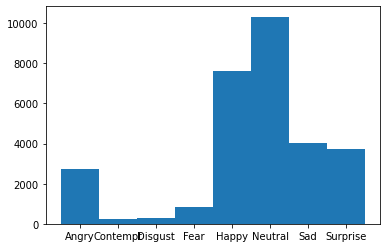

{'Angry': 2727,
 'Contempt': 245,
 'Disgust': 288,
 'Fear': 841,
 'Happy': 7603,
 'Neutral': 10324,
 'Sad': 4012,
 'Surprise': 3722}

In [8]:
train_count = counts(train_generator)
train_count

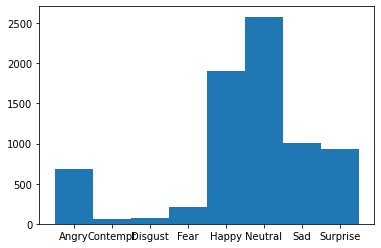

{'Angry': 681,
 'Contempt': 61,
 'Disgust': 72,
 'Fear': 210,
 'Happy': 1900,
 'Neutral': 2581,
 'Sad': 1003,
 'Surprise': 930}

In [9]:
validation_count = counts(validation_generator)
validation_count

In [10]:
train_generator, validation_generator = image_gen()
num_train = 29762
num_val = 7438
num_epoch = 80

Found 29762 images belonging to 8 classes.
Found 7438 images belonging to 8 classes.


In [11]:
def C_Model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))
    
    return model

Classify = C_Model()

2022-03-07 06:17:54.216003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 06:17:54.314780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 06:17:54.315577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 06:17:54.317848: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

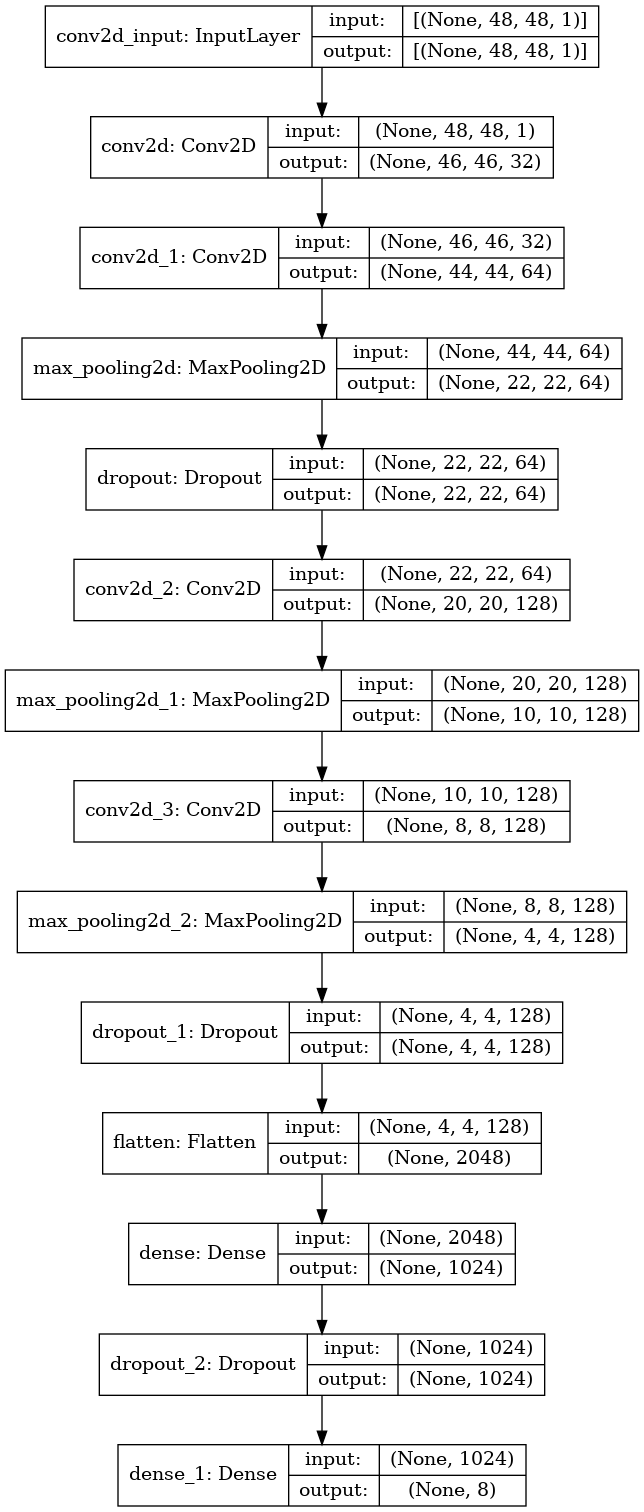

In [12]:
Image(model_to_dot(Classify, show_shapes=True).create_png())

In [13]:
def compile(model):
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001, decay=1e-6), metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch = num_train // batch_size,
        epochs = num_epoch,
        validation_data=validation_generator,
        validation_steps = num_val // batch_size)
    model.save_weights('model.h5')
    
    return history

history = compile(Classify)

2022-03-07 06:17:58.089517: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80


2022-03-07 06:17:59.516501: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


232/232 [==============================] - 32s 110ms/step - loss: 1.6390 - accuracy: 0.3557 - val_loss: 1.5227 - val_accuracy: 0.4184
Epoch 2/80
232/232 [==============================] - 25s 107ms/step - loss: 1.3999 - accuracy: 0.4965 - val_loss: 1.2447 - val_accuracy: 0.5594
Epoch 3/80
232/232 [==============================] - 25s 109ms/step - loss: 1.1974 - accuracy: 0.5726 - val_loss: 1.0958 - val_accuracy: 0.6065
Epoch 4/80
232/232 [==============================] - 25s 108ms/step - loss: 1.0711 - accuracy: 0.6173 - val_loss: 0.9761 - val_accuracy: 0.6491
Epoch 5/80
232/232 [==============================] - 24s 104ms/step - loss: 0.9993 - accuracy: 0.6435 - val_loss: 0.9348 - val_accuracy: 0.6598
Epoch 6/80
232/232 [==============================] - 30s 129ms/step - loss: 0.9483 - accuracy: 0.6588 - val_loss: 0.9033 - val_accuracy: 0.6762
Epoch 7/80
232/232 [==============================] - 25s 107ms/step - loss: 0.9056 - accuracy: 0.6726 - val_loss: 0.8668 - val_accuracy: 0.6

In [14]:
def save_model(model, model_name):
    model.save(model_name)

save_model(Classify, "Model_1.h5")

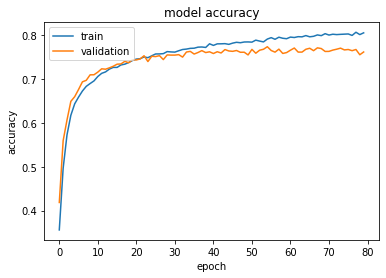

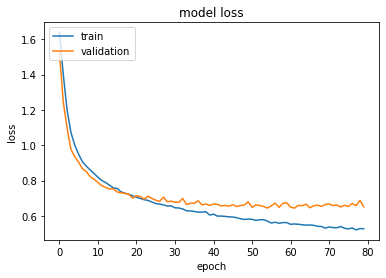

In [15]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_history(history)

In [16]:
# idx_to_emotion_fer = {0:"Disgust", 1:"Anger", 2:"Disgust", 3:"Fear", 4:"Happiness", 5:"Neutral", 6:"Sadness", 7:"Surprise"}

In [17]:
# def return_data(validation_generator):    
#     batch_index = 0
#     data = validation_generator[0]

#     while batch_index <= len(validation_generator):
#         if batch_index == 0:
#             X_test = np.array(data[0])
#             Y_test = np.array(data[1])
#         else:   
#             data = validation_generator.next()
#             X_test = np.append(X_test, data[0], axis=0)
#             Y_test = np.append(Y_test, data[1], axis=0)
#         batch_index = batch_index + 1
#     return X_test, Y_test

# X_test, Y_test = return_data(validation_generator)

In [18]:
# def evaluate(model, X_test, Y_test):
# #     model.load_weights(weights_path)
# #     y_pred = model.predict_generator(test_flow, steps=X_test.shape[0])
# #     y_pred_cat = np.argmax(y_pred, axis=1)
# #     y_true_cat = np.argmax(test_flow.y, axis=1)
    
#     y_predict = model.predict(X_test)
#     y_pred_cat = np.argmax(y_predict, axis=1)
#     y_true_cat = np.argmax(Y_test, axis=1)
#     report = classification_report(y_true_cat, y_pred_cat)
#     print(report)

#     conf = confusion_matrix(y_true_cat, y_pred_cat, normalize="true")

#     labels = idx_to_emotion_fer.values()
#     _, ax = plt.subplots(figsize=(8, 6))
#     ax = sns.heatmap(conf, annot=True, cmap='YlGnBu', 
#                      xticklabels=labels, 
#                      yticklabels=labels)

#     plt.show()

In [19]:
# evaluate(Classify, X_test, Y_test)